In [553]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)


In [554]:
df = pd.read_csv('data/train.csv')
df = pd.DataFrame(df)

print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (891, 12)
Columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [555]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [556]:
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [557]:
print("Info:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Info: None


Preliminary Findings:
1. Cabin has a lot of null values. So, dropping it.
2. Need to impute Age and Embarked.
3. PassengerID, Name, Ticket seem unrelated for this scenario. So, dropping these.
4. SibSp and Parch can be combined to create a new feature called "Family Size".

Data Visualization

In [558]:
df_num = df[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = df[['Survived', 'Pclass', 'Sex', 'Cabin', 'Embarked']]

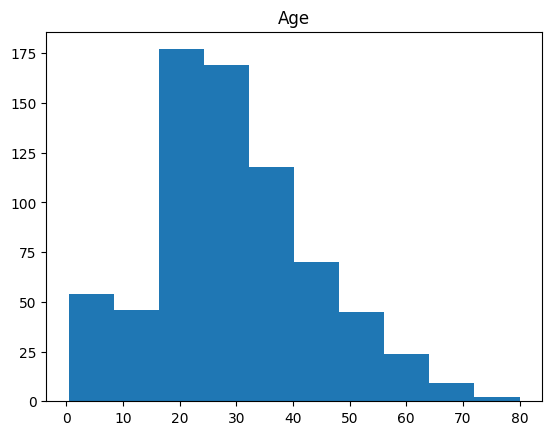

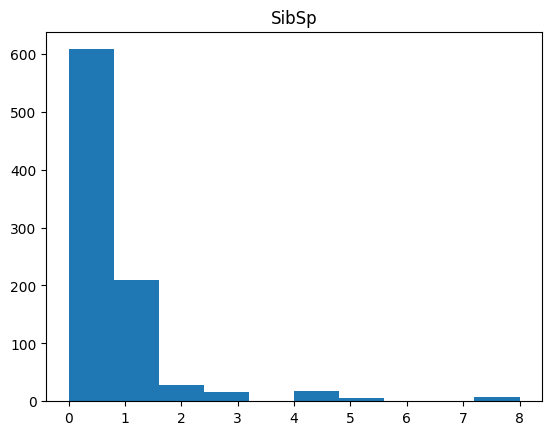

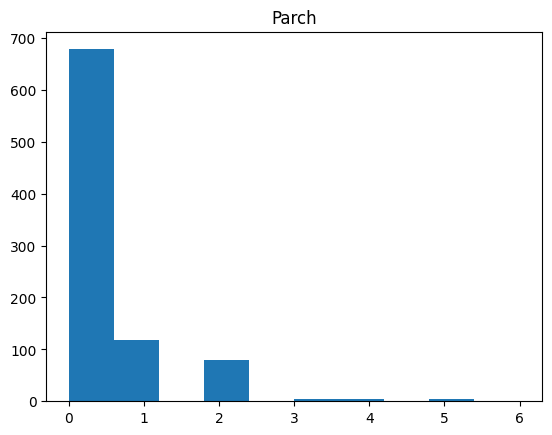

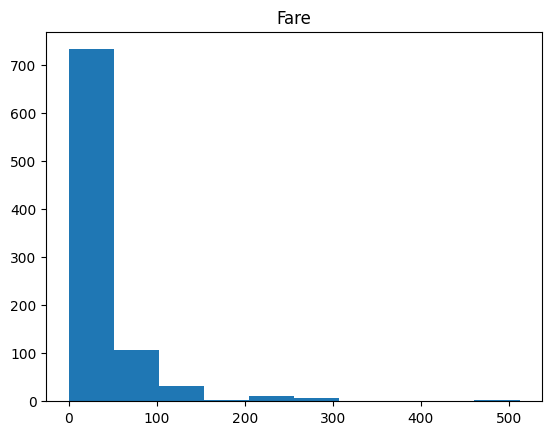

In [559]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

<Axes: >

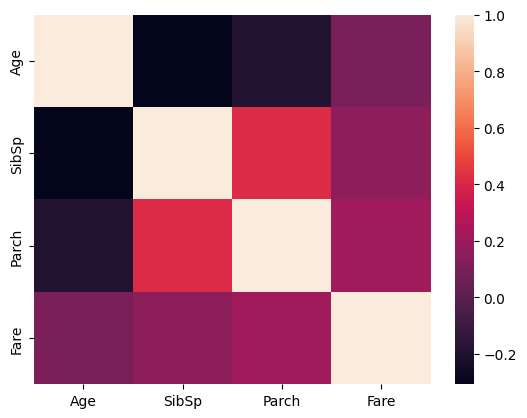

In [560]:
sns.heatmap(df_num.corr())

In [561]:
pd.pivot_table(df, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

Age       Fare     Parch     SibSp
Survived                                          
0         30.626179  22.117887  0.329690  0.553734
1         28.343690  48.395408  0.464912  0.473684

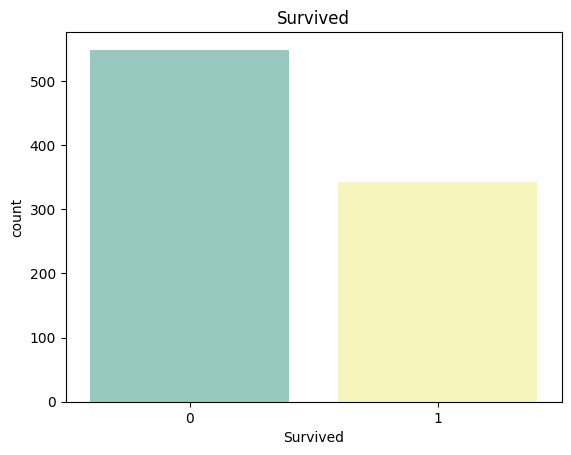

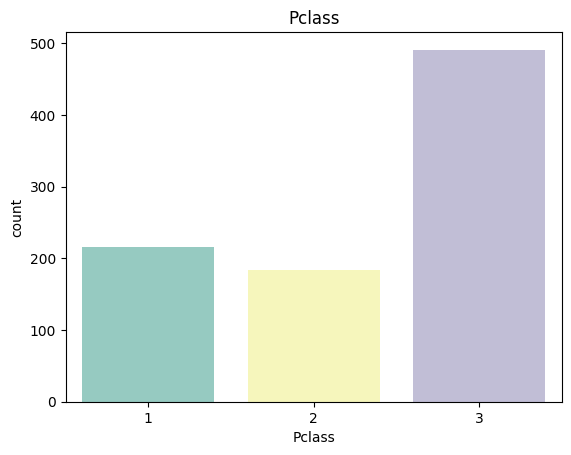

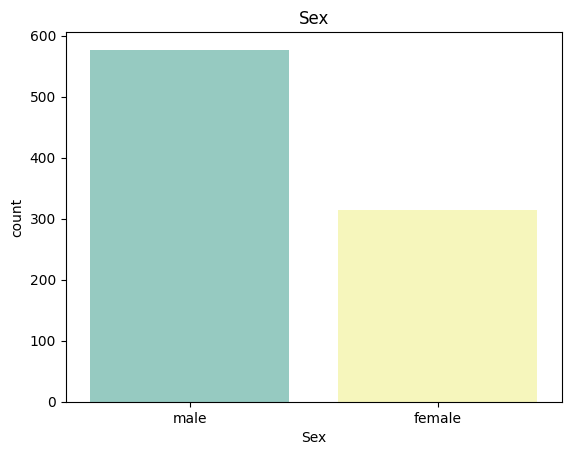

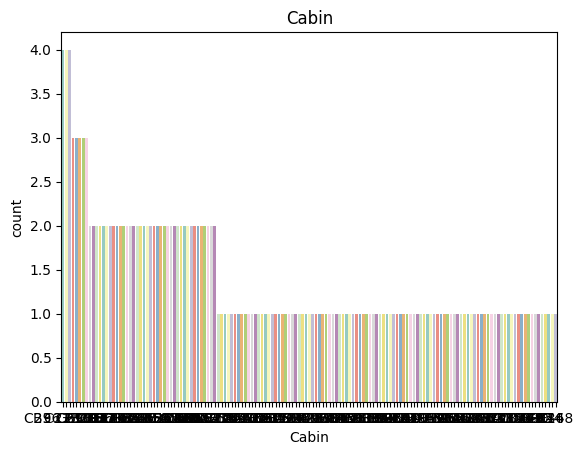

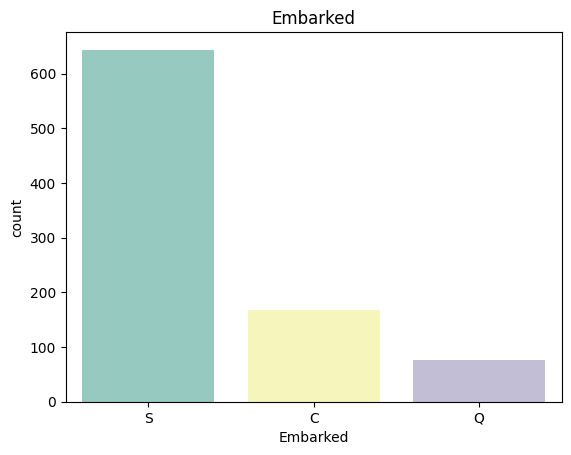

In [562]:
for i in df_cat.columns:
   sns.barplot(x = df_cat[i].value_counts().index, y= df_cat[i].value_counts(),hue=df_cat[i].value_counts().index, palette = 'Set3', legend = False).set_title(i)
   plt.show()

Pre-processing Train Data

In [563]:
# Dropping columns
cols = ['Name', 'PassengerId', 'Ticket', 'Cabin']

df = df.drop(cols, axis = 1)

In [564]:
# Creating a new feature by combining SibSp and Parch
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

In [565]:
# Categorical Encoding
df['Sex'] = df['Sex'].map({'male':0, 'female':1})
df['Embarked'] = df['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [566]:
df.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
Family_Size      0
dtype: int64

In [567]:
majority_class = df['Embarked'].isnull().sum()

# Impute Embarked with majority class
df['Embarked'] = df['Embarked'].fillna(majority_class)

<Axes: >

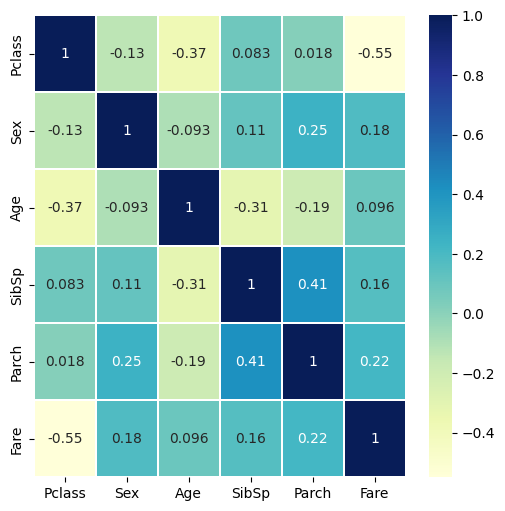

In [568]:
corr_matrix = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].corr()

plt.figure(figsize = (6, 6))
sns.heatmap(data = corr_matrix, cmap='YlGnBu', annot = True, linewidths = 0.2)

In [569]:
# Imputing Age with median Age of rows: PClass, SibSp and Parch due to correlation
NaN_indexes = df['Age'][df['Age'].isnull()].index

for i in NaN_indexes:
    pred_age = df['Age'][((df.SibSp == df.iloc[i]["SibSp"]) & (df.Parch == df.iloc[i]["Parch"]) & (df.Pclass == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(pred_age):
        df['Age'].iloc[i] = pred_age
    else:
        df['Age'].iloc[i] = df['Age'].median()

C:\Users\Fazle Labib\AppData\Local\Temp\ipykernel_2736\3655176710.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Age'].iloc[i] = pred_age
C:\Users\Fazle Labib\AppData\Local\Temp\ipykernel_2736\3655176710.py:7: SettingWithCopyWarning

In [570]:
df.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family_Size    0
dtype: int64

Pre-processing Test Data

In [571]:
df_test = pd.read_csv('data/test.csv')
df_test = pd.DataFrame(df_test)

test_passengerIDs = df_test["PassengerId"]

print("Shape:", df_test.shape)
print("Columns:", df_test.columns)

Shape: (418, 11)
Columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [572]:
# Dropping columns
cols = ['Name', 'PassengerId', 'Ticket', 'Cabin']

df_test = df_test.drop(cols, axis = 1)

In [573]:
# Creating a new feature by combining SibSp and Parch
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch'] + 1

In [574]:
# Categorical Encoding
df_test['Sex'] = df_test['Sex'].map({'male':0, 'female':1})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [575]:
df_test.isnull().sum()

Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
Family_Size     0
dtype: int64

In [576]:
majority_class = df_test['Fare'].isnull().sum()

# Impute Fare with majority class
df_test['Fare'] = df_test['Fare'].fillna(majority_class)

<Axes: >

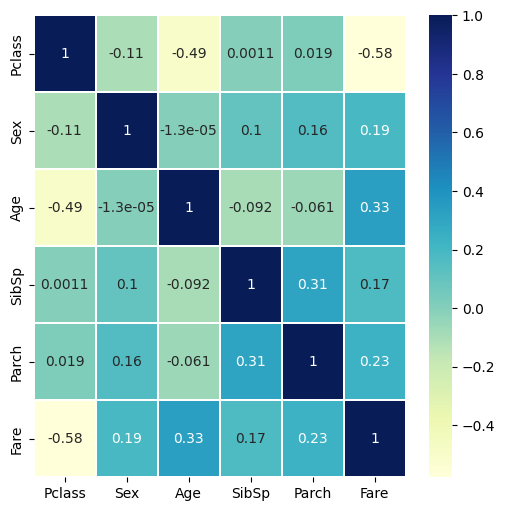

In [577]:
corr_matrix = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].corr()

plt.figure(figsize = (6, 6))
sns.heatmap(data = corr_matrix, cmap='YlGnBu', annot = True, linewidths = 0.2)

In [578]:
# Imputing Age with median Age of rows: PClass, SibSp and Parch due to correlation
NaN_indexes = df_test['Age'][df_test['Age'].isnull()].index

for i in NaN_indexes:
    pred_age = df_test['Age'][((df_test.SibSp == df_test.iloc[i]["SibSp"]) & (df_test.Parch == df_test.iloc[i]["Parch"]) & (df_test.Pclass == df_test.iloc[i]["Pclass"]))].median()
    if not np.isnan(pred_age):
        df_test['Age'].iloc[i] = pred_age
    else:
        df_test['Age'].iloc[i] = df_test['Age'].median()

C:\Users\Fazle Labib\AppData\Local\Temp\ipykernel_2736\1967914527.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test['Age'].iloc[i] = pred_age
C:\Users\Fazle Labib\AppData\Local\Temp\ipykernel_2736\1967914527.py:7: SettingWithCopyWa

In [579]:
df_test.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family_Size    0
dtype: int64

In [580]:
print(df.shape)
print(df_test.shape)

(891, 9)
(418, 8)


In [581]:
X_train = df.drop(columns='Survived')
y_train = df.Survived
y_train = pd.DataFrame({'Survived':y_train.values})

In [582]:
X_test = df_test

In [583]:
print(X_train.shape)
print(X_test.shape)

(891, 8)
(418, 8)


Run Predictions

In [584]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [585]:
# Initialize models
logistic_regression = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train models
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Make predictions on validation set
lr_pred = logistic_regression.predict(X_val)
rf_pred = random_forest.predict(X_val)
gb_pred = gradient_boosting.predict(X_val)

# Evaluate models
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Gradient Boosting Validation Accuracy:", accuracy_score(y_val, gb_pred))

# Ensemble: Voting Classifier
voting_classifier = VotingClassifier(estimators=[('lr', logistic_regression), 
                                                ('rf', random_forest), 
                                                ('gb', gradient_boosting)], 
                                     voting='hard')

# Train Voting Classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on validation set
vc_pred = voting_classifier.predict(X_val)

# Evaluate Voting Classifier
print("Voting Classifier Validation Accuracy:", accuracy_score(y_val, vc_pred))

# Cross-validation scores
lr_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5)
rf_scores = cross_val_score(random_forest, X_train, y_train, cv=5)
gb_scores = cross_val_score(gradient_boosting, X_train, y_train, cv=5)
vc_scores = cross_val_score(voting_classifier, X_train, y_train, cv=5)

print("Logistic Regression Cross-Validation Mean Accuracy:", lr_scores.mean())
print("Random Forest Cross-Validation Mean Accuracy:", rf_scores.mean())
print("Gradient Boosting Cross-Validation Mean Accuracy:", gb_scores.mean())
print("Voting Classifier Cross-Validation Mean Accuracy:", vc_scores.mean())

Logistic Regression Validation Accuracy: 0.8100558659217877
Random Forest Validation Accuracy: 0.8379888268156425
Gradient Boosting Validation Accuracy: 0.8044692737430168
Voting Classifier Validation Accuracy: 0.8212290502793296
Logistic Regression Cross-Validation Mean Accuracy: 0.7948980596867921
Random Forest Cross-Validation Mean Accuracy: 0.7907712006303556
Gradient Boosting Cross-Validation Mean Accuracy: 0.8258051807347583
Voting Classifier Cross-Validation Mean Accuracy: 0.821609376538954


In [586]:
# Define the parameter grid for Logistic Regression
logistic_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01]
}

# Perform grid search for Logistic Regression
logistic_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=logistic_param_grid, cv=5)
logistic_grid_search.fit(X_train, y_train)
best_logistic_params = logistic_grid_search.best_params_

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
best_rf_params = rf_grid_search.best_params_

# Perform grid search for Gradient Boosting
gb_grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)
best_gb_params = gb_grid_search.best_params_


In [587]:
# Initialize models with best hyperparameters
logistic_regression = LogisticRegression(**best_logistic_params)
random_forest = RandomForestClassifier(**best_rf_params)
gradient_boosting = GradientBoostingClassifier(**best_gb_params)

# Train models
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Make predictions on validation set
lr_pred = logistic_regression.predict(X_val)
rf_pred = random_forest.predict(X_val)
gb_pred = gradient_boosting.predict(X_val)

# Evaluate models
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Gradient Boosting Validation Accuracy:", accuracy_score(y_val, gb_pred))

# Ensemble: Voting Classifier
voting_classifier = VotingClassifier(estimators=[('lr', logistic_regression), 
                                                ('rf', random_forest), 
                                                ('gb', gradient_boosting)], 
                                     voting='hard')

# Train Voting Classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on validation set
vc_pred = voting_classifier.predict(X_val)

# Evaluate Voting Classifier
print("Voting Classifier Validation Accuracy:", accuracy_score(y_val, vc_pred))

# Cross-validation scores
lr_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5)
rf_scores = cross_val_score(random_forest, X_train, y_train, cv=5)
gb_scores = cross_val_score(gradient_boosting, X_train, y_train, cv=5)
vc_scores = cross_val_score(voting_classifier, X_train, y_train, cv=5)

print("Logistic Regression Cross-Validation Mean Accuracy:", lr_scores.mean())
print("Random Forest Cross-Validation Mean Accuracy:", rf_scores.mean())
print("Gradient Boosting Cross-Validation Mean Accuracy:", gb_scores.mean())
print("Voting Classifier Cross-Validation Mean Accuracy:", vc_scores.mean())


In [588]:
# Define the parameter distributions for Logistic Regression
logistic_param_dist = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Define the parameter distributions for Random Forest
rf_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20)
}

# Define the parameter distributions for Gradient Boosting
gb_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': [0.1, 0.05, 0.01]
}

# Perform random search for Logistic Regression
logistic_random_search = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=logistic_param_dist, n_iter=10, cv=5)
logistic_random_search.fit(X_train, y_train)
best_logistic_params = logistic_random_search.best_params_

# Perform random search for Random Forest
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_param_dist, n_iter=10, cv=5)
rf_random_search.fit(X_train, y_train)
best_rf_params = rf_random_search.best_params_

# Perform random search for Gradient Boosting
gb_random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=gb_param_dist, n_iter=10, cv=5)
gb_random_search.fit(X_train, y_train)
best_gb_params = gb_random_search.best_params_

In [589]:
# Initialize models with best hyperparameters
logistic_regression = LogisticRegression(**best_logistic_params)
random_forest = RandomForestClassifier(**best_rf_params)
gradient_boosting = GradientBoostingClassifier(**best_gb_params)

# Train models
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Make predictions on validation set
lr_pred = logistic_regression.predict(X_val)
rf_pred = random_forest.predict(X_val)
gb_pred = gradient_boosting.predict(X_val)

# Evaluate models
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Gradient Boosting Validation Accuracy:", accuracy_score(y_val, gb_pred))

# Ensemble: Voting Classifier
voting_classifier = VotingClassifier(estimators=[('lr', logistic_regression), 
                                                ('rf', random_forest), 
                                                ('gb', gradient_boosting)], 
                                     voting='hard')

# Train Voting Classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on validation set
vc_pred = voting_classifier.predict(X_val)

# Evaluate Voting Classifier
print("Voting Classifier Validation Accuracy:", accuracy_score(y_val, vc_pred))

# Cross-validation scores
lr_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5)
rf_scores = cross_val_score(random_forest, X_train, y_train, cv=5)
gb_scores = cross_val_score(gradient_boosting, X_train, y_train, cv=5)
vc_scores = cross_val_score(voting_classifier, X_train, y_train, cv=5)

print("Logistic Regression Cross-Validation Mean Accuracy:", lr_scores.mean())
print("Random Forest Cross-Validation Mean Accuracy:", rf_scores.mean())
print("Gradient Boosting Cross-Validation Mean Accuracy:", gb_scores.mean())
print("Voting Classifier Cross-Validation Mean Accuracy:", vc_scores.mean())


In [590]:
# Submitting predictions of Random Forest
submission_predictions = random_forest.predict(X_test)

submission_df = pd.DataFrame({"PassengerId": test_passengerIDs.values,
                   "Survived": submission_predictions,
                  })

In [591]:
# submission_df.to_csv("submission/submission.csv", index=False)